In [ ]:
pip install pydicom

In [ ]:
!pip install pickle5

     |████████████████████████████████| 133kB 5.1MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219241 sha256=5a72e4ba56ca45750f357cfe5c83bd82920b7b1609eb0690f98d45c952d7dfd3
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [ ]:
!pip install hiddenlayer

In [ ]:
import os
import sys
import pandas as pd
from glob import glob
import pickle5 as pickle
import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import numpy as np
from pathlib import Path
import six
import csv
import logging
import math
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
#import dicom2nifti
import nibabel as nib
from PIL import Image 
import scipy.misc
from scipy import stats
from sklearn.model_selection import train_test_split
from datetime import datetime
from scipy.spatial import distance
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.anchor_utils import AnchorGenerator
import torch.optim as optim
import hiddenlayer as hl


In [ ]:
# Mount the google drive so that we can access the data stored in the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Preprocessing

In [ ]:
BATCH_SIZE = 6

In [ ]:
img_arrays_path = '/content/gdrive/MyDrive/223C_breast_cancer/DBT_DATA/IMG_ARRAYS/'
boxes_path = '/content/gdrive/MyDrive/223C_breast_cancer/DBT_DATA/TRAINING_DATA/BCS-DBT boxes-train-v2.csv'
df_boxes = pd.read_csv(boxes_path)


87

In [ ]:
# Get the classification labels for all 224 cases
labels_unsplit = []
for i in range(len(df_boxes)):
  if df_boxes['Class'][i] == 'cancer':
    labels_unsplit.append(1)
  else:
    labels_unsplit.append(0)

In [ ]:
# A method for saving the image names of the 224 cases which have the labels.
def select_cases_with_boxes(img_arrays_path, boxes_path):
  df_boxes = pd.read_csv(boxes_path)
  img_names = glob(os.path.join(img_arrays_path, '*.pickle'))
  img_names[0].split('_')[5]
  img_names_valid = []
  for i in range(len(df_boxes)):
    for j in range(len(img_names)):
      img_studyID = img_names[j].split('_')[5]
      view = img_names[j].split('_')[6]
      if df_boxes['StudyUID'][i] == img_studyID and df_boxes['View'][i] == view:
        img_names_valid.append(img_names[j])
  return img_names_valid 

# Customized Dataset class. This will be used with Dataloader to make training easy to code later.
class BreastDataset(Dataset):
  def __init__(self, df_boxes, img_names, batch_size, transform=None):
    self.df_boxes = df_boxes
    self.img_names = img_names
    self.batch_size = batch_size

  def __len__(self):
    return len(self.df_boxes)

  # Whenever we call the Dataloader during training, it will automatically iterate through each item returned by this function.
  # It returns the image arrays, bounding box, and target label.
  def __getitem__(self, index):
    # A helper function to do zero padding on images so that we have the same size for all images.
    def padding(array, xx, yy):
    
      h = array.shape[0]
      w = array.shape[1]

      a = (xx - h) // 2
      aa = xx - a - h

      b = (yy - w) // 2
      bb = yy - b - w

      return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')
      
    # Get the image slice where the bounding box resides
    img_array = pickle.load(open(self.img_names[index], "rb" ))
    box_slice_index = self.df_boxes['Slice'][index]
    img_slice = img_array[box_slice_index, :, :]
    # Normalize the image (min max norm)
    img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())
    img_slice = padding(img_slice, 2457, 1996)
    # Convert into a 3 channel image
    img_slice = np.stack((img_slice,)*3, axis = 0)
    img_slice = torch.from_numpy(img_slice.astype(np.float32))
    img_slice = img_slice.to(device = torch.device('cuda:0'))

    # Create the label based on the file name
    if 'Benign' in os.path.basename(self.img_names[index]):
      label = torch.tensor([0])
      label = label.to(device = torch.device('cuda:0'))
    elif 'Cancer' in os.path.basename(self.img_names[index]):
      label = torch.tensor([1])
      label = label.to(device = torch.device('cuda:0'))
    
    # Get the bounding box 
    box = [df_boxes['X'][index], df_boxes['Y'][index], df_boxes['Width'][index], df_boxes['Height'][index]]

    # transform from [x, y, w, h] to [x1, y1, x2, y2]
    box[2] = box[0] + box[2]
    box[3] = box[1] + box[3]
    
    box = torch.as_tensor(box)
    box = box.to(device = torch.device('cuda:0'))
    target = {}
    target["boxes"] = box
    target["labels"] = label

    return img_slice, [target] * self.batch_size

In [ ]:
img_names_valid = select_cases_with_boxes(img_arrays_path, boxes_path)

In [ ]:
img_names = glob(os.path.join(img_arrays_path, '*.pickle'))
img_names[0].split('_')


['/content/gdrive/MyDrive/223C',
 'breast',
 'cancer/DBT',
 'DATA/IMG',
 'ARRAYS/DBT-P03324',
 'DBT-S03541',
 'rcc',
 'Normal.pickle']

In [ ]:
breast_dataset = BreastDataset(df_boxes, img_names_valid, BATCH_SIZE)


In [ ]:

# For testing the code only. Using 2 samples.
# toy_dataset = BreastDataset(df_boxes.head(10), img_names_valid[0:10])
# toy_dataloader = DataLoader(toy_dataset, batch_size = 2, shuffle = True, num_workers = 0)

In [ ]:
# Stratified train, val, test split. First do train-test split, and then take out validation set from the training set.
train_indices, test_indices = train_test_split(
    np.arange(len(labels_unsplit)), test_size = 0.1, shuffle = True, stratify = labels_unsplit, random_state = 123)
train_indices, val_indices = train_test_split(
    train_indices, test_size = 0.1, shuffle = True, stratify = [labels_unsplit[i] for i in train_indices], random_state = 123)

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Create the dataloader using the Dataset class and the splitting indices.
train_dataloader = DataLoader(breast_dataset, batch_size = BATCH_SIZE, shuffle = False, sampler = train_sampler, num_workers = 0)
val_dataloader = DataLoader(breast_dataset, batch_size = BATCH_SIZE, shuffle = False, sampler = val_sampler, num_workers = 0)
test_dataloader = DataLoader(breast_dataset, batch_size = BATCH_SIZE, shuffle = False, sampler = test_sampler, num_workers = 0)

### Training and validation phase

In [ ]:
# Train and validate the model in a user specified number of epochs
def train_val(resume_training, num_epochs):
  num_epochs = num_epochs
  start_epoch = 0  # start from epoch 0 or last epoch

  retinanet = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 2, pretrained = False, pretrained_backbone = True, detections_per_img = 10) 
  retinanet = retinanet.to(device = torch.device('cuda:0'))
  optimizer = optim.SGD(retinanet.parameters(), lr=0.001, momentum=0.9)

  global best_loss
  best_loss = float('inf')  # best test loss
  n_epochs_stop = 5
  epochs_no_improve = 0
  min_delta = 0.5
  early_stop = False

  if resume_training:
    print('==> Resuming from checkpoint..')
    checkpoint = torch.load('/content/gdrive/MyDrive/223C_breast_cancer/code/model_10_epochs_early_stopping_10detections.pth')
    retinanet.load_state_dict(checkpoint['net'])
    best_loss = checkpoint['loss']
    start_epoch = checkpoint['epoch']

  total_epoch_loss_train = []
  total_epoch_loss_val = []
  start_time = datetime.now()

  ''' Training phase '''

  for epoch in range(start_epoch, start_epoch + num_epochs): 
    # Training phase
    retinanet.train()
    epoch_loss = 0
    epoch_classification_loss = 0
    epoch_regression_loss = 0
    # For each epoch, we see the entire training and validation set once.
    # This inner loop is to loop through batches of training data
    for batch_num, (image, targets) in enumerate(train_dataloader):

      optimizer.zero_grad()
      outputs = retinanet.forward(image, targets)
      classification_loss = outputs['classification']
      regression_loss = outputs['bbox_regression']
      loss = classification_loss + regression_loss 
      loss.backward()
      
      optimizer.step()
      epoch_classification_loss += float(classification_loss)
      epoch_regression_loss += float(epoch_regression_loss)
      epoch_loss += float(loss)

    total_epoch_loss_train.append(epoch_loss/len(train_dataloader))
    print('\n Training')
    print('Epoch: {} | Regression loss: {:1.5f} | Classification loss: {:1.5f} | Epoch loss: {:1.5f}'.format(
        epoch, regression_loss, epoch_classification_loss/(batch_num + 1), epoch_loss/(batch_num + 1)))
    
    ''' Validation phase '''

    epoch_loss_val = 0
    epoch_classification_loss_val = 0
    epoch_regression_loss_val = 0
    # For each epoch, we see the entire training and validation set once.
    # This inner loop is to loop through batches of validation data
    for batch_num, (image, targets) in enumerate(val_dataloader):
      outputs_val = retinanet.forward(image, targets)
      classification_loss_val = outputs_val['classification']
      regression_loss_val = outputs_val['bbox_regression']
      loss_val = classification_loss_val + regression_loss_val
      
      epoch_classification_loss_val += float(classification_loss_val)
      epoch_regression_loss_val += float(epoch_regression_loss_val)
      epoch_loss_val += float(loss_val)

    total_epoch_loss_val.append(epoch_loss_val/len(val_dataloader))
    print('\n Validation')
    print('Epoch: {} | Regression loss: {:1.5f} | Classification loss: {:1.5f} | Epoch loss: {:1.5f}'.format(
        epoch, regression_loss_val, epoch_classification_loss_val/(batch_num + 1), epoch_loss_val/(batch_num + 1)))
    
    # # Predictions from the model
    # retinanet.eval()
    # predictions = retinanet.forward(image)
    # print(predictions)
    retinanet.train()
    val_loss = epoch_loss_val/(len(val_dataloader))
    
    # Plot loss for each epoch
    plt.plot(range(epoch+1), total_epoch_loss_train, label = 'Training')
    plt.plot(range(epoch+1), total_epoch_loss_val, label = 'Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Check if need to do early stopping
    if best_loss - val_loss > min_delta:
      best_loss = val_loss
      epochs_no_improve = 0
    else:
      epochs_no_improve += 1
    if epochs_no_improve == n_epochs_stop:
      print('Early stopping!' )
      early_stop = True
      break
    else:
      print('Save model')
      state = {
        'net': retinanet.state_dict(),
        'loss': val_loss,
        'epoch': epoch,
      }
      torch.save(state, '/content/gdrive/MyDrive/223C_breast_cancer/code/model_10_epochs_early_stopping_10detections.pth')


  # After finishing all the epochs
  end_time = datetime.now()
  print('Duration: {}'.format(end_time - start_time))

#train_val(resume_training = False, num_epochs = 10)

### Testing phase

Average sensitivity at 2FP:
https://github.com/MaciejMazurowski/duke-dbt-data/blob/master/duke_dbt_data.py

FP_count = 0
Starting from the box with the highest confidence score, calculate if it's a TP based on the distance criteria. If is FP, count it and record its index. When the count equals 2, return the confidence score and its index. True positive rate is then equal to (the number of TP boxes at that threshold) / (the current iteration index)

http://spie-aapm-nci-dair.westus2.cloudapp.azure.com/competitions/4

In [ ]:
# Load the trained model weights 
retinanet = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 2, pretrained = False, pretrained_backbone = True) 
checkpoint = torch.load('/content/gdrive/MyDrive/223C_breast_cancer/code/model_20_epochs.pth')
retinanet.load_state_dict(checkpoint['net'])
retinanet.to(device = torch.device('cuda:0'))
retinanet.eval()



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [ ]:
test_dataset = [breast_dataset[i] for i in test_indices]

In [ ]:
# Reference: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
	boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

# A box is true positive if the center between this box and the ground truth box is less than
# either 1/2 ground truth box diagonal, or 100 pixels less.
def is_true_positive_box(boxA, boxB):
  centerX_boxA = (boxA[0] + boxA[2]) / 2
  centerY_boxA = (boxA[1] + boxA[3]) / 2

  centerX_boxB = (boxB[0] + boxB[2]) / 2
  centerY_boxB = (boxB[1] + boxB[3]) / 2

  euc_distance = distance.euclidean((centerX_boxA, centerY_boxA), (centerX_boxB, centerY_boxB))

  half_diag_length_target_box = math.sqrt((boxB[2] - boxB[0])**2 + (boxB[3] - boxB[1])**2)

  if euc_distance < (half_diag_length_target_box/2) or euc_distance < 100:
    return True
  else:
    return False



In [ ]:
# Quantitative evaluation on the test set
def evaluate_retinanet(test_dataset):
  num_FP = 2
  pred_boxes = []
  target_boxes = []
  pred_labels = []
  target_labels = []
  IoUs = []
  
  sensitivity_across_cases = []
  # fig,axes = plt.subplots(nrows = 1, ncols = 8, figsize=(24,8))
  #for i, ax in enumerate(axes.flatten()):
  for i in range(len(test_dataset)):
    test_sample = test_dataset[i]
    test_image = [test_sample[0]]
    test_box = [test_sample[1][0]['boxes']]
    test_label = [test_sample[1][0]['labels']]
    test_box = test_box[0].detach().cpu().numpy()
    test_label = test_label[0].detach().cpu().numpy()
    target_labels.append(test_label)
    target_boxes.append(test_box)

    predictions = retinanet.forward(test_image)
    output = [{k: v.detach().cpu().numpy() for k, v in t.items()} for t in predictions]

    # plt.sca(ax)
    # test_image = test_image[0].detach().cpu().numpy()
    # plt.imshow(test_image[0, :, :], cmap='gray')

    num_true_positives = 0
    num_false_positives = 0
    for output_index in range(output[0]['labels'].shape[0]):
      if num_false_positives < num_FP:
        pred_box = output[0]['boxes'][output_index]
        pred_label = output[0]['labels'][output_index]
        
        if is_true_positive_box(pred_box, test_box):
          print('TP')
          num_true_positives += 1
        else:
          print('XX')
          num_false_positives += 1

        # change to (x, y, w, h) 
        # pred_box[2] -= pred_box[0]
        # pred_box[3] -= pred_box[1]

        # test_box[2] -= test_box[0]
        # test_box[3] -= test_box[1]
        # plt.gca().add_patch(Rectangle((pred_box[0], pred_box[1]),pred_box[2], pred_box[3], linewidth=1, edgecolor='r', facecolor='none'))
      else:
        #sensitivity_this_case = num_true_positives / output[0]['labels'].shape[0]
        sensitivity_this_case = num_true_positives / (output_index + 1)
        sensitivity_across_cases.append(sensitivity_this_case)
        break
  mean_sensitivity = np.mean(sensitivity_across_cases)
  return sensitivity_across_cases, mean_sensitivity




In [ ]:
sensitivity_across_cases, mean_sensitivity = evaluate_retinanet(test_dataset)


XX
XX
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
XX
XX
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
XX
XX
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
XX
TP
TP
XX
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
XX
XX
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
XX
TP
TP
TP
TP
XX
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
XX
TP
TP
XX
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
XX
XX
TP
TP
TP
TP
TP
TP
XX
XX
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
XX
TP
XX
XX
XX
XX
XX
TP
TP
TP
TP
XX
XX
TP
TP
XX
XX
TP
TP
XX
XX
TP
TP
XX
XX
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
XX
XX
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
TP
XX
TP
XX
XX
XX
XX
XX
TP
TP
TP
TP
TP
T

In [ ]:
mean_sensitivity

0.6011383780152816

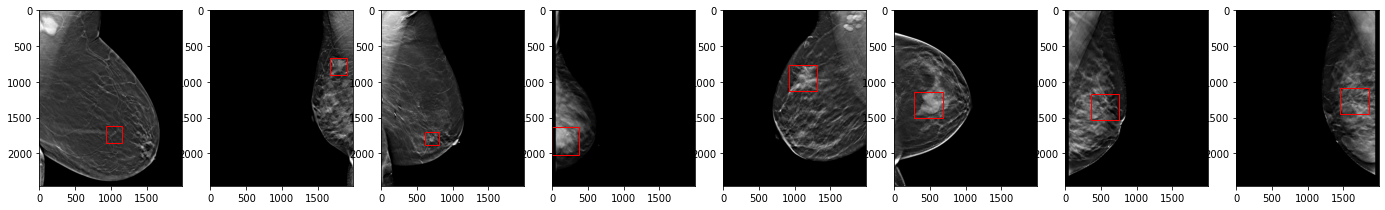

In [ ]:
def plot_pred_boxes():
  fig,axes = plt.subplots(nrows = 1, ncols = 8, figsize=(24,8))
  for i, ax in enumerate(axes.flatten()):
    test_sample = test_dataset[i]
    test_image = [test_sample[0]]
    test_box = [test_sample[1][0]['boxes']]
    test_label = [test_sample[1][0]['labels']]
    test_box = test_box[0].detach().cpu().numpy()
    test_label = test_label[0].detach().cpu().numpy()

    predictions = retinanet.forward(test_image)
    output = [{k: v.detach().cpu().numpy() for k, v in t.items()} for t in predictions]

    test_image = test_image[0].detach().cpu().numpy()
    plt.sca(ax)
    plt.imshow(test_image[0, :, :], cmap='gray')

    # Only plot the bounding box with the highest confidence score
    for output_index in range(0, 1):
      pred_box = output[0]['boxes'][output_index]
      pred_label = output[0]['labels'][output_index]
    
      # change to (x, y, w, h) 
      pred_box[2] -= pred_box[0]
      pred_box[3] -= pred_box[1]
      test_box[2] -= test_box[0]
      test_box[3] -= test_box[1]
      
      # if np.asarray(pred_label) == 1:
      #   plt.title('Cancer')
      # else:
      #   plt.title('Benign')
      plt.gca().add_patch(Rectangle((pred_box[0], pred_box[1]),pred_box[2], pred_box[3], linewidth=1, edgecolor='r', facecolor='none'))
    #plt.gca().add_patch(Rectangle((test_box[0], test_box[1]), test_box[2], test_box[3], linewidth=1, edgecolor='r', facecolor='none'))
plot_pred_boxes()